## Hyman Minsky's Financial Instability Hypothesis and Minsky Moments

Hyman Minsky, an American economist, developed the Financial Instability Hypothesis (FIH), which emphasizes the dynamics of financial markets and their role in shaping economic cycles. His theory proposes that financial systems inherently tend toward periods of boom and bust due to the cyclical fluctuations in investor behavior and economic stability.

### Financial Instability Hypothesis

Minsky's model is built on the observation that during prosperous times, firms and consumers alike tend to increase their debt, becoming progressively riskier in their financial behaviors. This leads to what Minsky identified as three types of borrowers:
- **Hedge Borrowers:** Can pay back both the interest and principal from their cash flows.
- **Speculative Borrowers:** Can cover the interest but must continually roll over the principal.
- **Ponzi Borrowers:** Cannot cover the interest or principal from their operations and must borrow further or sell assets to meet their obligations.

As the economy grows, the proportion of speculative and Ponzi borrowers increases, elevating the financial risk within the system.

### Minsky Moments

A "Minsky Moment" is a sudden market collapse that follows a long period of bullish growth, typically caused by the unsustainable accumulation of debt by speculative and Ponzi borrowers. When these borrowers fail to meet their debt obligations due to a downturn or tightening credit conditions, it can lead to a rapid deflation of asset prices, increased volatility, and a retrenchment of economic activity.

These moments are characterized by:
- Rapid deleveraging
- Falling asset prices
- Abrupt slowdowns in economic activity

### Implications

The FIH and the concept of Minsky Moments have become particularly relevant in discussions of economic policy and regulation, especially following the global financial crisis of 2007-2008, which many analysts consider a quintessential Minsky Moment. Minsky's work suggests that to prevent such crises, regulatory measures should focus on curtailing excessive debt accumulation and managing the cyclical expansions of financial behavior.

Minsky's insights challenge the traditional views of financial markets always moving toward equilibrium, emphasizing instead the potential for sudden and severe economic instability due to internal market dynamics.


In [40]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import norm
from arch import arch_model
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
import os

import mplcyberpunk
plt.style.use("cyberpunk")


In [41]:
# Define file paths

series_list = '/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/Data/Series_List.csv'
pop_projections = '/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/Data/US_Census_Pop_Projections.csv'
df = pd.read_csv(series_list)
countries = pd.read_csv('/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/Data/Country Keys.csv')

# Correctly select specific columns
country = countries[['Country', 'GDP_SeriesID', 'Stock_index']]
# Example: Selecting the GDP_SeriesID for the USA
select = 'United States'

gdp_series_id = country.loc[country['Country'] == select, 'GDP_SeriesID'].values[0]
title = country.loc[country['Country'] == select, 'Country'].values[0]

# Assuming 'df' contains columns like 'DATE' and many GDP series
df = df[['DATE', gdp_series_id,'USJO', 'USE', 'USU', 'USP', 'FFR', 'Inflation', 'DJIA']] # Selecting DATE and the specific GDP series column
df = df.rename(columns={gdp_series_id: 'GDP'})  # Rename the GDP series column

# Clean up data

print(df)


          DATE        GDP    USJO           USE          USU       USP  \
0     1/1/1950   586526.0     NaN   58761.33333  3946.000000  150786.0   
1     4/1/1950   604420.5     NaN   59457.66667  3458.666667  151319.0   
2     7/1/1950   627781.8     NaN   59643.00000  2897.666667  151973.0   
3    10/1/1950   639803.5     NaN   59899.33333  2617.666667  152658.0   
4     1/1/1951   648491.8     NaN   59899.00000  2182.333333  153291.0   
..         ...        ...     ...           ...          ...       ...   
292   1/1/2023  5528082.3  9348.0  160891.00000  5849.000000  334547.0   
293   4/1/2023  5556337.5  8864.0  161419.66670  5943.000000  334934.0   
294   7/1/2023  5622673.0  7820.0  161443.00000  6197.000000  335430.0   
295  10/1/2023  5668214.8  7718.0  161195.33330  6324.333333  335923.0   
296        NaN        NaN     NaN           NaN          NaN       NaN   

          FFR   Inflation      DJIA  
0         NaN   23.586667    200.52  
1         NaN   23.766667    206.00

In [42]:
df1 = pd.read_csv(pop_projections)
df1

,Date,US_Proj-hi,US_Proj-lo,US_Proj-0
0,2022,333287557,333287557,333287557
1,2023,335674990,334393850,333368934
2,2024,338020369,335456707,333405763
3,2025,340326253,336476277,333396257
4,2026,342598169,337456326,333342777
...,...,...,...,...
74,2096,432979495,322447563,234003714
75,2097,433584277,321597831,231989880
76,2098,434180387,320745279,229977910
77,2099,434767856,319890085,227968092


In [43]:
def get_observations_before_date_v3(df, date_column, date_str, num_observations):
    """
    Extracts a specified number of observations from a DataFrame immediately before a given date using a date column.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the column that contains the date values.
        date_str (str): The target date in 'YYYY-MM-DD' format.
        num_observations (int): The number of observations to retrieve before the date.

    Returns:
        pd.DataFrame: A subset of the original DataFrame with the specified number of observations before the date.
    """
    # Convert the date column to datetime if not already
    df[date_column] = pd.to_datetime(df[date_column])

    # Sort the DataFrame by the date column to ensure chronological order
    df.sort_values(by=date_column, inplace=True)

    # Filter the DataFrame to only include rows before the target date
    before_date_df = df[df[date_column] < pd.to_datetime(date_str)]

    # Select the last 'num_observations' entries from this filtered DataFrame
    if len(before_date_df) > num_observations:
        df_subset = before_date_df.iloc[-num_observations:]
    else:
        df_subset = before_date_df  # In case there are fewer rows than 'num_observations'

    return df_subset
cut_date = '2016-10-31'
subset_df = get_observations_before_date_v3(df, 'DATE', cut_date, 295)

#df = subset_df # activate this line to apply function

df 

,DATE,GDP,USJO,USE,USU,USP,FFR,Inflation,DJIA
0,1950-01-01,586526.0,NaN,58761.33333,3946.000000,150786.0,NaN,23.586667,200.52
1,1950-04-01,604420.5,NaN,59457.66667,3458.666667,151319.0,NaN,23.766667,206.00
2,1950-07-01,627781.8,NaN,59643.00000,2897.666667,151973.0,NaN,24.203333,209.10
3,1950-10-01,639803.5,NaN,59899.33333,2617.666667,152658.0,NaN,24.693333,226.30
4,1951-01-01,648491.8,NaN,59899.00000,2182.333333,153291.0,NaN,25.696667,235.40
...,...,...,...,...,...,...,...,...,...
292,2023-01-01,5528082.3,9348.0,160891.00000,5849.000000,334547.0,4.516667,301.203000,33147.25
293,2023-04-01,5556337.5,8864.0,161419.66670,5943.000000,334934.0,4.990000,303.466667,33274.15
294,2023-07-01,5622673.0,7820.0,161443.00000,6197.000000,335430.0,5.260000,306.034333,34407.60
295,2023-10-01,5668214.8,7718.0,161195.33330,6324.333333,335923.0,5.330000,308.099000,33507.50


First, pick a stock you would like to forcast from yahoo finance. For the purposes of demonstration we will use quarterly data of the DJIA 

## Overview of Explosive Unit Root Analysis Using SADF and GSADF Tests

The provided Python code implements the SADF and GSADF tests to detect explosive behavior (unit roots) in time series data. These tests are useful for identifying speculative bubbles or other forms of non-stationarity within economic data, which might indicate periods of excessive price increases followed by abrupt corrections.

### Initial Settings

- **`r0`**: The initial proportion of the sample used for the minimum window size for the rolling tests. It is set based on a formula that adjusts with the square root of the sample size `T`.
- **`swindow0`**: The actual size of the initial window converted from the proportion `r0`.
- **`dim`**: The number of test statistics that will be calculated, based on the total sample size `T` minus the size of the initial window `swindow0`.
- **`date`**: An array of dates that correspond to the length of the data, assuming quarterly frequency starting from the first index of the merged dataset.

### Functions

- **`simulate_critical_values(num_simulations, T, r0)`**: This function simulates critical values for the SADF/GSADF tests. It does so by repeatedly generating a unit root process and calculating the ADF statistic for each simulation. The critical values for the 90%, 95%, and 99% confidence levels are then derived from these simulated statistics.

### Calculation of SADF and GSADF Statistics

- **SADF Calculation**:
  - The SADF statistic is computed using a rolling window approach where the ADF test is applied to expanding windows of data starting from the initial window size to the end of the series.
  - The maximum ADF statistic from these windows is taken as the SADF statistic, indicating the strongest evidence of a unit root within any window.

- **GSADF Calculation**:
  - Similar to the SADF, but the GSADF allows for both starting and ending points of the window to vary.
  - This test computes the ADF statistic for every possible window combination within the dataset, starting from the initial window size.
  - The maximum of these statistics is the GSADF statistic, providing a more flexible test that can detect multiple periods of explosive behavior.

### Output

- The code outputs the calculated SADF and GSADF statistics and compares them against the critical values derived from the simulations. It also prints the length of the GSADF statistics array and the corresponding dates, which helps in identifying the specific time periods of potential explosive behavior.

### Usage

- The code is set up to analyze a series (likely stock prices or similar financial data) stored in the variable `price`.
- Users can adjust the number of simulations and the sample size `T` as needed based on their specific dataset and the desired accuracy of the test results.


In [44]:
merged_df = df
T = len(merged_df)
price = merged_df['DJIA']

In [45]:
# Initial settings for the SADF test window
r0 = 0.01 + 1.8 / np.sqrt(T)
swindow0 = int(np.floor(r0 * T))
dim = T - swindow0 + 1
date = pd.date_range(start= merged_df.index[0], periods=T, freq='Q-DEC')

def simulate_critical_values(num_simulations, T, r0):
    critical_values = []
    for _ in range(num_simulations):
        # Generate a unit root process
        series = np.random.normal(size=T).cumsum()
        stat = adfuller(series, maxlag=int(r0*T), regression='c', autolag=None)[0]
        critical_values.append(stat)
    
    # Determine the 90%, 95%, and 99% critical values
    critical_values = np.percentile(critical_values, [90, 95, 99])
    return critical_values

# Example usage
num_simulations = 2000

critical_values = simulate_critical_values(num_simulations, T, r0)
print("Critical values at 90%, 95%, 99%:", critical_values)


Critical values at 90%, 95%, 99%: [-0.19268744  0.30026822  1.10024651]


In [46]:
# Calculate the SADF statistic
dateS = date[swindow0:]

badfs = np.zeros(dim)
for i in range(swindow0, T):
    result = adfuller(price[:i+1], maxlag=2, regression='c', autolag=None)
    badfs[i - swindow0] = result[0]
sadf = np.max(badfs)

print('The SADF statistic:', sadf)

The SADF statistic: 8.807445200633872


In [47]:
# Calculate the Generalized GSADF statistic
bsadfs = np.zeros(dim)
for r2 in range(swindow0, T):
    dim0 = r2 - swindow0 + 1
    rwadft = np.zeros(dim0)
    for r1 in range(dim0):
        result = adfuller(price[r1:r2+1], maxlag=2, regression='c', autolag=None)
        rwadft[r1] = result[0]
    bsadfs[r2 - swindow0] = np.max(rwadft)

gsadf = np.max(bsadfs)

print('The GSADF statistic:', gsadf)
print('The critical values:', critical_values)
bsadfs = bsadfs[:-1]
len(bsadfs),len(dateS)


The GSADF statistic: 8.807445200633872
The critical values: [-0.19268744  0.30026822  1.10024651]


(264, 264)

In [48]:
# Assuming bsadfs, merged_df, and other necessary variables are already defined
# Print current lengths to understand the situation
print("Length of dateS:", len(dateS))
print("Length of bsadfs before trimming:", len(bsadfs))
print("Length of badfs:", len(badfs))

# Trim bsadfs if it's longer than merged_df
if len(bsadfs) > len(merged_df):
    bsadfs = bsadfs[-len(merged_df):]  # Trim from the beginning to match the end
elif len(bsadfs) < len(merged_df):
    # Calculate the number of missing periods
    missing_periods = len(merged_df) - len(bsadfs)
    # Create an array of NaNs for the missing periods
    initial_nans = np.full(missing_periods, np.nan)
    # Concatenate the NaNs with the bsadfs array to align with the end of merged_df
    bsadfs = np.concatenate((initial_nans, bsadfs))

# Add the bsadfs array to the DataFrame
merged_df['GSADF_Stat'] = bsadfs

# Optional: Drop rows with NaNs in the 'GSADF_Stat' if needed
merged_df = merged_df.dropna(subset=['GSADF_Stat'])
print(merged_df)


Length of dateS: 264
Length of bsadfs before trimming: 264
Length of badfs: 265
          DATE        GDP    USJO           USE          USU       USP  \
33  1958-04-01   785306.0     NaN   62979.33333  4993.666667  173729.0   
34  1958-07-01   803471.0     NaN   63498.00000  4975.000000  174483.0   
35  1958-10-01   822258.0     NaN   63939.66667  4316.333333  175288.0   
36  1959-01-01   838032.3     NaN   64772.00000  3944.666667  176045.0   
37  1959-04-01   856916.8     NaN   64875.00000  3493.000000  176727.0   
..         ...        ...     ...           ...          ...       ...   
292 2023-01-01  5528082.3  9348.0  160891.00000  5849.000000  334547.0   
293 2023-04-01  5556337.5  8864.0  161419.66670  5943.000000  334934.0   
294 2023-07-01  5622673.0  7820.0  161443.00000  6197.000000  335430.0   
295 2023-10-01  5668214.8  7718.0  161195.33330  6324.333333  335923.0   
296        NaT        NaN     NaN           NaN          NaN       NaN   

          FFR   Inflation      

In [49]:
def add_transformations(df, columns):
    """
    Add log, first difference, and log difference transformations to specified columns.

    Parameters:
    df (DataFrame): The DataFrame to modify.
    columns (list of str): List of column names to transform.

    Returns:
    DataFrame: The modified DataFrame with new columns.
    """
    for col in columns:
        # Calculate log of the column
        df[f'Log_{col}'] = np.log(df[col])

        # Calculate first difference of the column
        #df[f'{col}_Diff'] = df[col].diff()

        # Calculate first difference of the log of the column
        #df[f'Log_{col}_Diff'] = df[f'Log_{col}'].diff()

    # Drop the initial NaN values resulting from differencing
    df = df.dropna()

    return df

# Define the columns you want to transform
columns_to_transform = ['GDP', 'DJIA','USJO', 'USU', 'USP', 'Inflation']

# Apply the transformations
merged_df.set_index('DATE', inplace=True)
merged_df = merged_df.apply(pd.to_numeric, errors='coerce')

merged_df = add_transformations(merged_df, columns_to_transform)



In [50]:
df = df.dropna()

# Display the resulting merged DataFrame
merged_df

,GDP,USJO,USE,USU,USP,FFR,Inflation,DJIA,GSADF_Stat,Log_GDP,Log_DJIA,Log_USJO,Log_USU,Log_USP,Log_Inflation
DATE,,,,,,,,,,,,,,,
2001-01-01,3545780.0,4752.0,137088.0000,6084.333333,284169.0,5.593333,175.900000,10786.85,4.704444,15.081269,9.286083,8.466321,8.713472,12.557324,5.169916
2001-04-01,3567923.5,4125.0,136719.3333,6327.000000,284838.0,4.326667,177.133333,9878.78,3.216151,15.087494,9.198144,8.324821,8.752581,12.559676,5.176903
2001-07-01,3553629.0,3937.0,136225.6667,6922.333333,285584.0,3.496667,177.633333,10502.40,3.660219,15.083480,9.259359,8.278174,8.842508,12.562291,5.179722
2001-10-01,3563393.5,3249.0,136105.3333,7985.000000,286311.0,2.133333,177.500000,8847.56,1.557399,15.086224,9.087897,8.086103,8.985320,12.564834,5.178971
2002-01-01,3593196.3,3289.0,136360.0000,8233.666667,286935.0,1.733333,178.066667,10021.50,2.129485,15.094553,9.212488,8.098339,9.015987,12.567011,5.182158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,5497495.3,9538.0,160425.6667,5868.000000,334201.0,3.653333,298.441000,28725.51,1.193594,15.519803,10.265541,9.163039,8.677269,12.719498,5.698572
2023-01-01,5528082.3,9348.0,160891.0000,5849.000000,334547.0,4.516667,301.203000,33147.25,2.495601,15.525352,10.408715,9.142918,8.674026,12.720533,5.707784
2023-04-01,5556337.5,8864.0,161419.6667,5943.000000,334934.0,4.990000,303.466667,33274.15,2.562521,15.530450,10.412536,9.089753,8.689969,12.721689,5.715272


In [51]:
merged_df.to_csv('/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/Data/vecm_data.csv', index=True)  # creating csv of this data
merged_df


,GDP,USJO,USE,USU,USP,FFR,Inflation,DJIA,GSADF_Stat,Log_GDP,Log_DJIA,Log_USJO,Log_USU,Log_USP,Log_Inflation
DATE,,,,,,,,,,,,,,,
2001-01-01,3545780.0,4752.0,137088.0000,6084.333333,284169.0,5.593333,175.900000,10786.85,4.704444,15.081269,9.286083,8.466321,8.713472,12.557324,5.169916
2001-04-01,3567923.5,4125.0,136719.3333,6327.000000,284838.0,4.326667,177.133333,9878.78,3.216151,15.087494,9.198144,8.324821,8.752581,12.559676,5.176903
2001-07-01,3553629.0,3937.0,136225.6667,6922.333333,285584.0,3.496667,177.633333,10502.40,3.660219,15.083480,9.259359,8.278174,8.842508,12.562291,5.179722
2001-10-01,3563393.5,3249.0,136105.3333,7985.000000,286311.0,2.133333,177.500000,8847.56,1.557399,15.086224,9.087897,8.086103,8.985320,12.564834,5.178971
2002-01-01,3593196.3,3289.0,136360.0000,8233.666667,286935.0,1.733333,178.066667,10021.50,2.129485,15.094553,9.212488,8.098339,9.015987,12.567011,5.182158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,5497495.3,9538.0,160425.6667,5868.000000,334201.0,3.653333,298.441000,28725.51,1.193594,15.519803,10.265541,9.163039,8.677269,12.719498,5.698572
2023-01-01,5528082.3,9348.0,160891.0000,5849.000000,334547.0,4.516667,301.203000,33147.25,2.495601,15.525352,10.408715,9.142918,8.674026,12.720533,5.707784
2023-04-01,5556337.5,8864.0,161419.6667,5943.000000,334934.0,4.990000,303.466667,33274.15,2.562521,15.530450,10.412536,9.089753,8.689969,12.721689,5.715272


In [52]:
# Define color variables
color_job_openings = 'cyan'
color_bsadf_stat = 'red'
color_stock_index = 'limegreen'
color_gdp = 'yellow'
color_population = 'blue'
color_unemployment = 'magenta'
color_employment = 'orange'
color_inflation = 'pink'
color_FFR = 'green'
axis_color = 'white' 

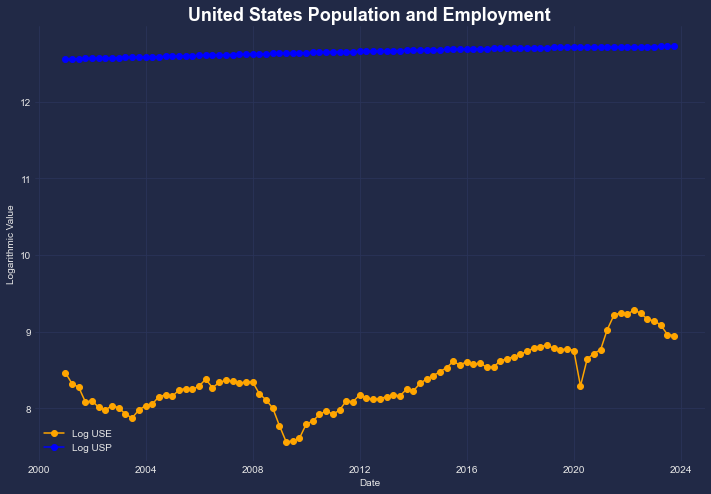

In [53]:
plt.figure(figsize=(12, 8))

plt.plot(merged_df.index, merged_df['Log_USJO'], label='Log USE', marker='o', color=color_employment)
plt.plot(merged_df.index, merged_df['Log_USP'], label='Log USP', marker='o', color=color_population)

plt.title(f'{select} Population and Employment', color=axis_color, fontsize=18, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Logarithmic Value')
plt.legend()
plt.grid(True)

plt.savefig(f'/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/{select} Pop_Growth & Employment.jpeg', format='jpeg')

plt.show()

In [54]:
# Stationarity Test
def perform_adf_test(series, regression_type='ct'):
    """
    Perform an Augmented Dickey-Fuller test on a given time series.

    Parameters:
        series (pd.Series): The time series on which to perform the ADF test.
        regression_type (str): The type of regression ('c' for constant, 'ct' for constant and trend, 'ctt' for constant, and linear and quadratic trend, 'nc' for no constant, no trend).

    Returns:
        None
    """
    result = adfuller(series, regression=regression_type)
    print(f"ADF Statistic for {series.name}: {result[0]}")
    print(f"p-value for {series.name}: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[0] < result[4]['10%']:
        print(f"Reject the null hypothesis - the {series.name} series is stationary at the 90% confidence level.")
    else:
        print(f"Fail to reject the null hypothesis - the {series.name} series is not stationary at the 90% confidence level.")


In [55]:
for column in merged_df.columns:
    result = perform_adf_test(merged_df[column], regression_type='ct')
    print(f'ADF Test for {column}:\n{result}\n')

ADF Statistic for GDP: -2.66157432355011
p-value for GDP: 0.2523809192114633
Critical Values:
	1%: -4.062
	5%: -3.460
	10%: -3.156
Fail to reject the null hypothesis - the GDP series is not stationary at the 90% confidence level.
ADF Test for GDP:
None

ADF Statistic for USJO: -1.6280078810215741
p-value for USJO: 0.7812735447065013
Critical Values:
	1%: -4.069
	5%: -3.463
	10%: -3.158
Fail to reject the null hypothesis - the USJO series is not stationary at the 90% confidence level.
ADF Test for USJO:
None

ADF Statistic for USE: -3.1488789791829186
p-value for USE: 0.09507773721840995
Critical Values:
	1%: -4.062
	5%: -3.460
	10%: -3.156
Fail to reject the null hypothesis - the USE series is not stationary at the 90% confidence level.
ADF Test for USE:
None

ADF Statistic for USU: -2.9555564050010514
p-value for USU: 0.14493322641364853
Critical Values:
	1%: -4.062
	5%: -3.460
	10%: -3.156
Fail to reject the null hypothesis - the USU series is not stationary at the 90% confidence lev

<Figure size 720x360 with 0 Axes>

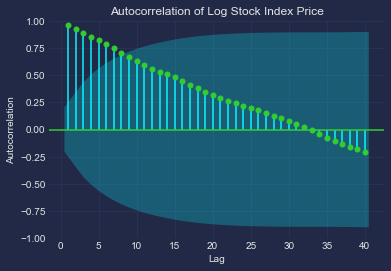

<Figure size 720x360 with 0 Axes>

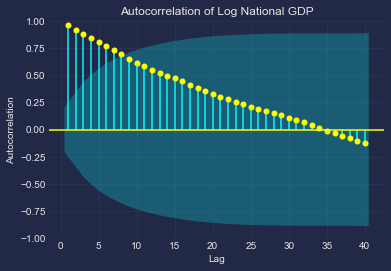

<Figure size 720x360 with 0 Axes>

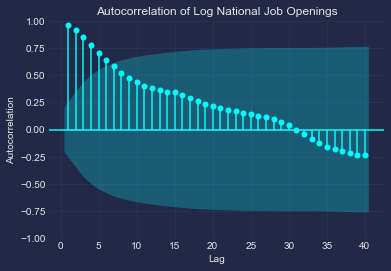

<Figure size 720x360 with 0 Axes>

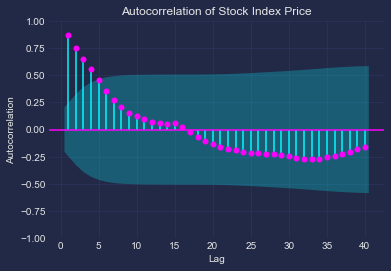

<Figure size 720x360 with 0 Axes>

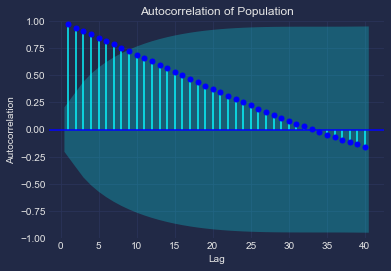

<Figure size 720x360 with 0 Axes>

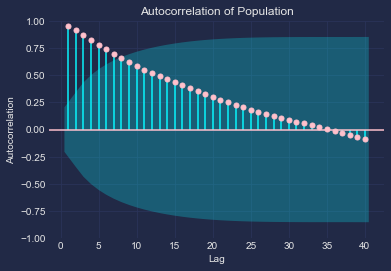

<Figure size 720x360 with 0 Axes>

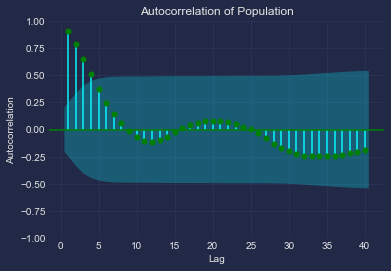

<Figure size 720x360 with 0 Axes>

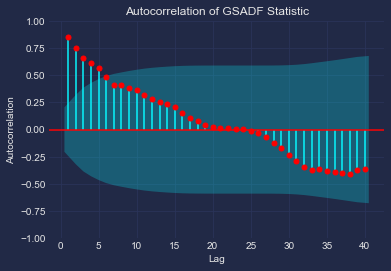

In [56]:
# Plot Correlogram for Log Stock Index Price
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_DJIA'], lags=40, zero=False, title='Autocorrelation of Log Stock Index Price', color=color_stock_index)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for Log GDP
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_GDP'], lags=40, zero=False, title='Autocorrelation of Log National GDP', color=color_gdp)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

#Plot Correlogram for Log US Job Openings
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_USJO'], lags=40, zero=False, title='Autocorrelation of Log National Job Openings', color=color_job_openings)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for Log Unemployment
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_USU'], lags=40, zero=False, title='Autocorrelation of Stock Index Price', color=color_unemployment)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for Log Population
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_USP'], lags=40, zero=False, title='Autocorrelation of Population', color=color_population)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for Log Inflation
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Log_Inflation'], lags=40, zero=False, title='Autocorrelation of Population', color=color_inflation)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for FFR
plt.figure(figsize=(10, 5))
plot_acf(merged_df['FFR'], lags=40, zero=False, title='Autocorrelation of Population', color=color_FFR)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for GSADF Statistic
plt.figure(figsize=(10, 5))
plot_acf(merged_df['GSADF_Stat'], lags=40, zero=False, title='Autocorrelation of GSADF Statistic', color=color_bsadf_stat)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

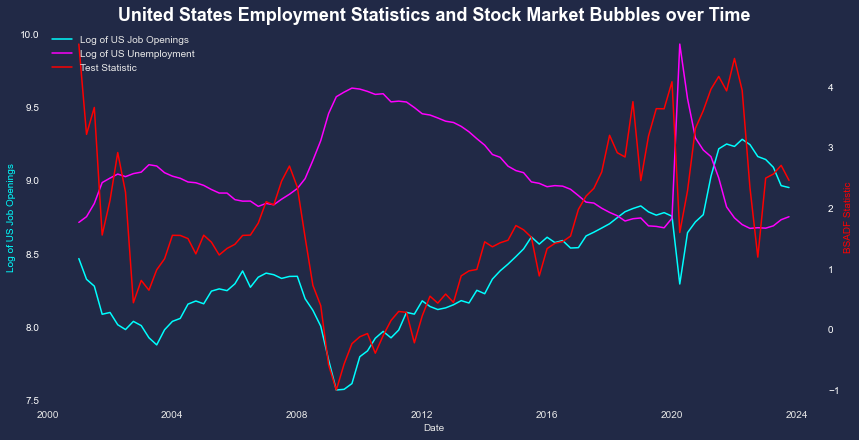

In [57]:

# Create the plot with specified figure size
plt.figure(figsize=(14, 7))
ax1 = plt.gca()  # Get the current axes instance

# Plotting Job Openings on the left y-axis
ax1.plot(merged_df.index, merged_df['Log_USJO'], label='Log of US Job Openings', color=color_job_openings)
ax1.plot(merged_df.index, merged_df['Log_USU'], label='Log of US Unemployment', color=color_unemployment)

ax1.set_xlabel('Date')
ax1.set_ylabel('Log of US Job Openings', color=color_job_openings)
ax1.tick_params(axis='y', colors=axis_color)
ax1.grid(False)  # Disable gridlines for the primary axis

# Create a second y-axis for the BSADF Statistic data
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['GSADF_Stat'], label='Test Statistic', color=color_bsadf_stat)
ax2.set_ylabel('BSADF Statistic', color=color_bsadf_stat)
ax2.tick_params(axis='y', colors=axis_color)
ax2.grid(False)  # Disable gridlines for the secondary axis

# Title and legend handling
plt.title(f'{select} Employment Statistics and Stock Market Bubbles over Time', color=axis_color, fontsize=18, fontweight='bold')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')  # Adjust location as needed

# Save the plot to the specified directory and file
plt.savefig(f'/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/{select}_Unemployment_Test_Stat.jpeg', format='jpeg')

# Show the plot
plt.show()


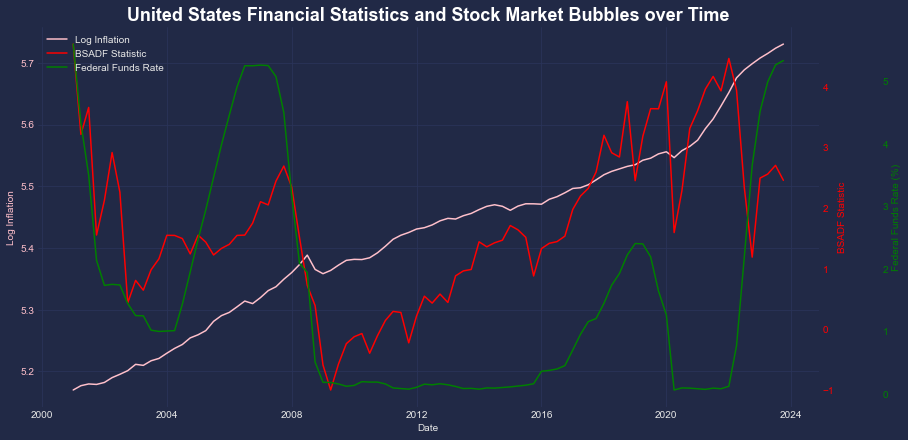

In [58]:
import matplotlib.pyplot as plt

# Assuming you have defined 'merged_df' and the colors appropriately

# Create the plot with specified figure size
plt.figure(figsize=(14, 7))
ax1 = plt.gca()  # Get the current axes instance

# Plotting Log Inflation on the primary y-axis
ax1.plot(merged_df.index, merged_df['Log_Inflation'], label='Log Inflation', color=color_inflation)
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Inflation', color=color_inflation)
ax1.tick_params(axis='y', colors=color_inflation)
ax1.grid(True)  

# Create a second y-axis for the BSADF Statistic data
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['GSADF_Stat'], label='BSADF Statistic', color=color_bsadf_stat)
ax2.set_ylabel('BSADF Statistic', color=color_bsadf_stat)
ax2.tick_params(axis='y', colors=color_bsadf_stat)
ax2.grid(False)  # Disable gridlines for the secondary axis

# Create a third y-axis for the Federal Funds Rate data
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right
ax3.plot(merged_df.index, merged_df['FFR'], label='Federal Funds Rate', color=color_FFR)
ax3.set_ylabel('Federal Funds Rate (%)', color=color_FFR)
ax3.tick_params(axis='y', colors=color_FFR)
ax3.grid(False) 

# Title and legend handling
plt.title(f'{select} Financial Statistics and Stock Market Bubbles over Time', color= axis_color, fontsize=18, fontweight='bold')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')  # Adjust location as needed

# Save the plot to the specified directory and file
plt.savefig(f'/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/{select}_FFR_Inflation_Stat.jpeg', format='jpeg')

# Show the plot
plt.show()


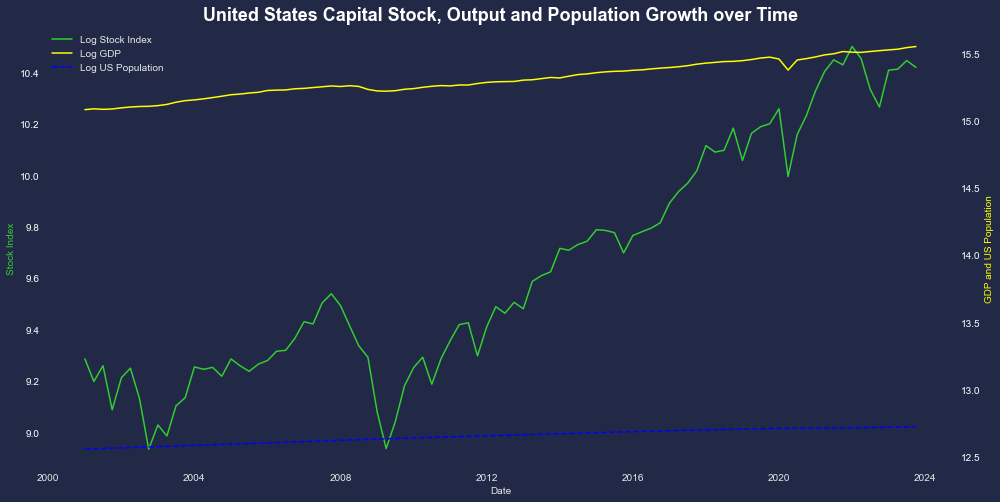

In [59]:
# Create a figure and a set of subplots with the desired size
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Price data on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Index', color=color_stock_index)
ax1.plot(merged_df.index, merged_df['Log_DJIA'], color=color_stock_index, label='Log Stock Index')
ax1.tick_params(axis='y', labelcolor=axis_color)
ax1.grid(False)  # Disable gridlines for the primary axis

# Create a second y-axis for the GDP and US Prices data
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('GDP and US Population', color=color_gdp)  # We already handled the x-label with ax1
ax2.plot(merged_df.index, merged_df['Log_GDP'], color=color_gdp, label='Log GDP')
ax2.plot(merged_df.index, merged_df['Log_USP'], color=color_population, linestyle='--', label='Log US Population')  # Corrected label
ax2.tick_params(axis='y', labelcolor=axis_color)
ax2.grid(False)  # Disable gridlines for the secondary axis

# Title and layout
plt.title('Stock Index, National GDP, and US Prices Over Time')
fig.tight_layout()  # Otherwise the right y-label is slightly clipped

# Add legend to differentiate the data series
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')  # Adjust location as needed
plt.title(f'{select} Capital Stock, Output and Population Growth over Time', color=axis_color, fontsize=18, fontweight='bold')

# Save the plot to the specified directory and file
plt.savefig(f'/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/{select}_Index_Price_GDP_USP.jpeg', format='jpeg')

# Show the plot
plt.show()


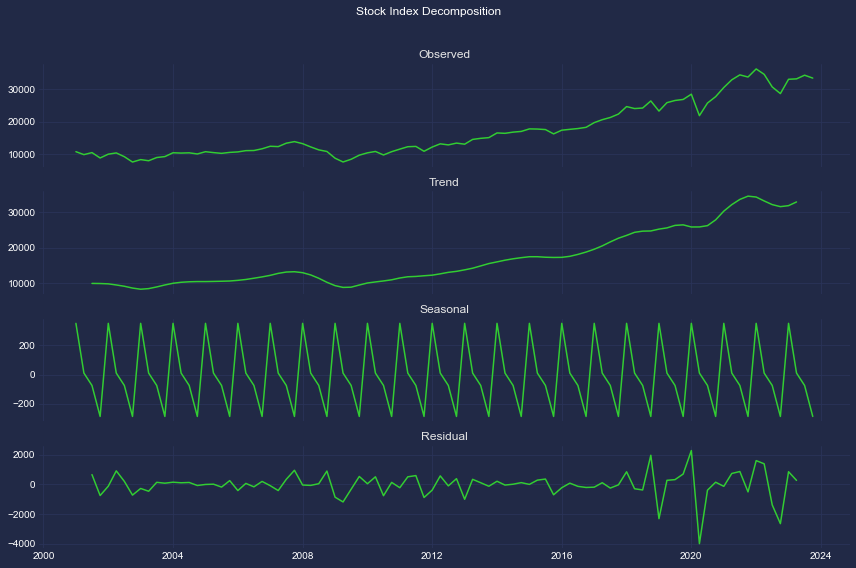

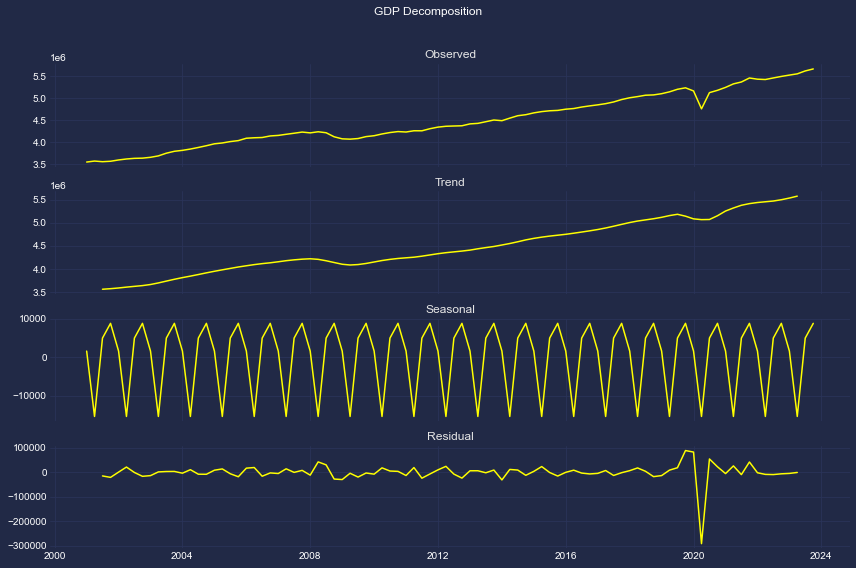

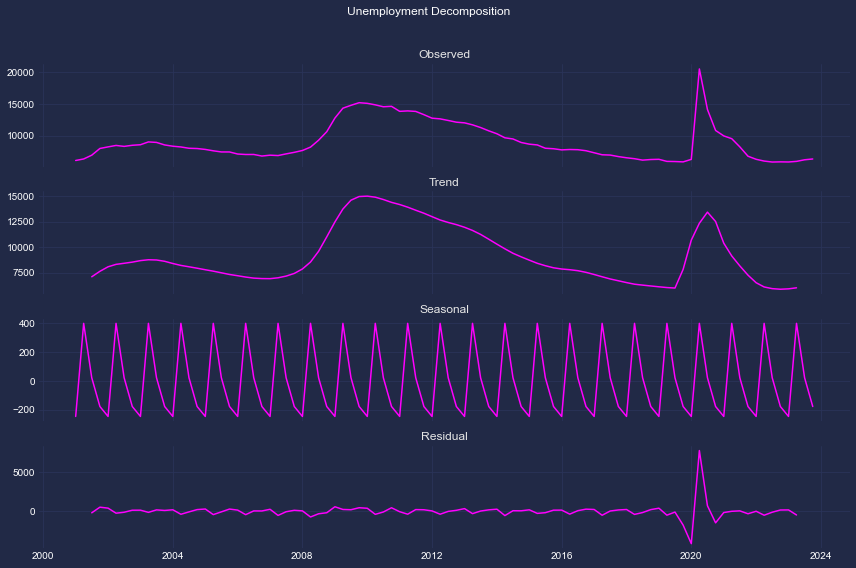

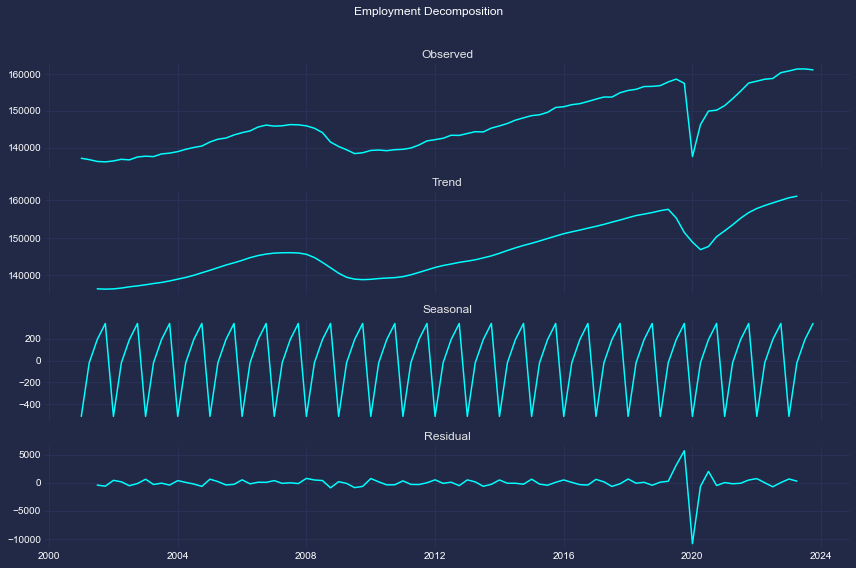

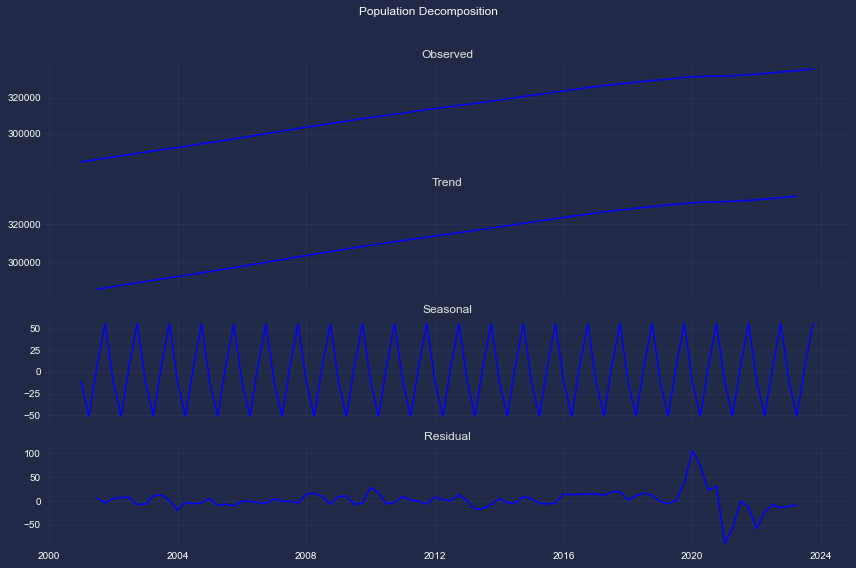

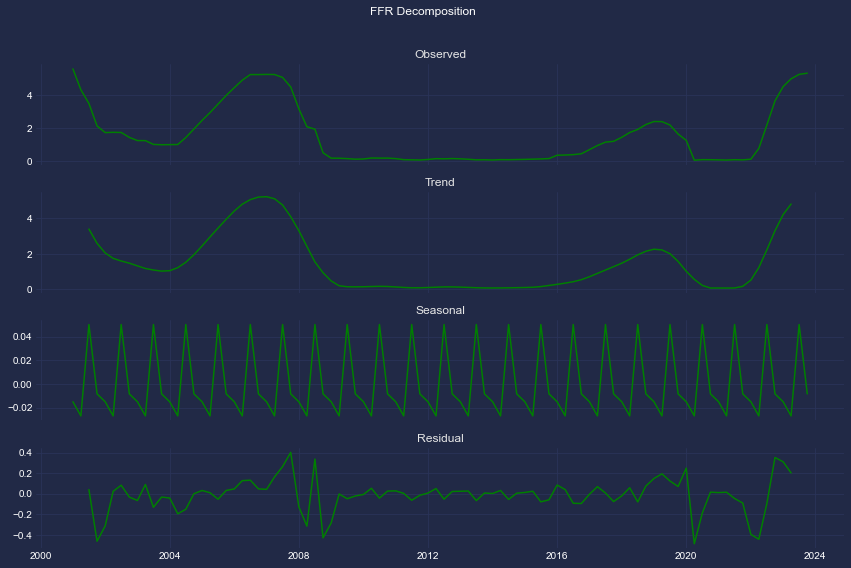

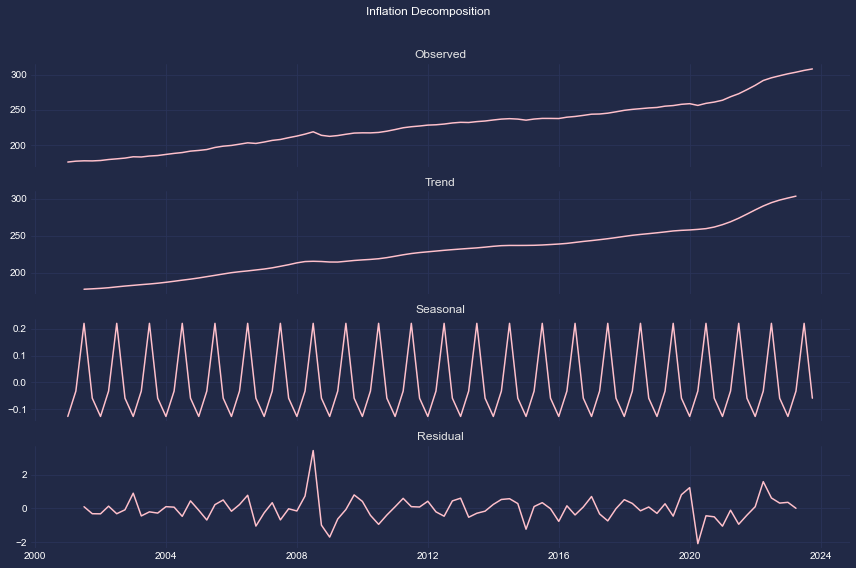

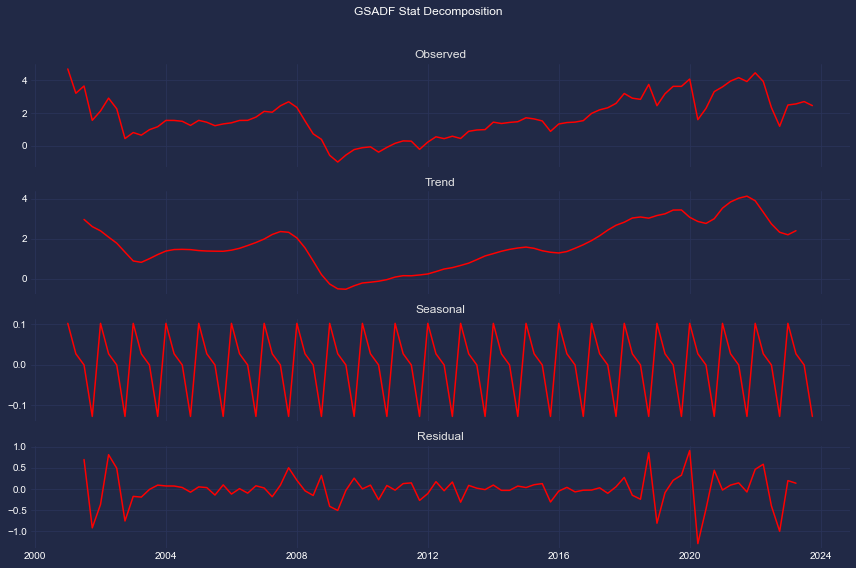

Index(['GDP', 'USJO', 'USE', 'USU', 'USP', 'FFR', 'Inflation', 'DJIA',
       'GSADF_Stat', 'Log_GDP', 'Log_DJIA', 'Log_USJO', 'Log_USU', 'Log_USP',
       'Log_Inflation'],
      dtype='object')

In [60]:
# Customize plotting function
def customize_plot(result, title, color):
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 8))
    axes[0].plot(result.observed, color=color)
    axes[0].set_title('Observed')
    
    axes[1].plot(result.trend, color=color)
    axes[1].set_title('Trend')
    
    axes[2].plot(result.seasonal, color=color)
    axes[2].set_title('Seasonal')
    
    axes[3].plot(result.resid, color=color)
    axes[3].set_title('Residual')
    
    for ax in axes:
        ax.tick_params(axis='x', colors=axis_color)
        ax.tick_params(axis='y', colors=axis_color)

    plt.suptitle(title, color=axis_color)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    

# Applying the function to each series
# Decompose and plot Stock Index data
result_price = seasonal_decompose(merged_df['DJIA'], model='additive', period=4)  
customize_plot(result_price, 'Stock Index Decomposition', color_stock_index)

# Decompose and plot GDP data
result_gdp = seasonal_decompose(merged_df['GDP'], model='additive', period=4)  
customize_plot(result_gdp, 'GDP Decomposition', color_gdp)

# Decompose and plot Unemployment data
result_job_openings = seasonal_decompose(merged_df['USU'], model='additive', period=4)  
customize_plot(result_job_openings, 'Unemployment Decomposition', color_unemployment)

# Decompose and plot Job Openings data
result_job_openings = seasonal_decompose(merged_df['USE'], model='additive', period=4)  
customize_plot(result_job_openings, 'Employment Decomposition', color_job_openings)

# Decompose and plot Population data
result_population = seasonal_decompose(merged_df['USP'], model='additive', period=4)  
customize_plot(result_population, 'Population Decomposition', color_population)
# Decompose and plot Population data
result_population = seasonal_decompose(merged_df['FFR'], model='additive', period=4)  
customize_plot(result_population, 'FFR Decomposition', color_FFR)
# Decompose and plot Population data
result_population = seasonal_decompose(merged_df['Inflation'], model='additive', period=4)  
customize_plot(result_population, 'Inflation Decomposition', color_inflation)
# Decompose and plot GSADF data
result_gsadf = seasonal_decompose(merged_df['GSADF_Stat'], model='additive', period=4)  
customize_plot(result_gsadf, 'GSADF Stat Decomposition', color_bsadf_stat)

merged_df.columns


In [61]:
data = merged_df[['Log_DJIA', 'Log_GDP', 'Log_USJO', 'Log_USU', 'Log_USP',  'Log_Inflation', 'GSADF_Stat']]


data

,Log_DJIA,Log_GDP,Log_USJO,Log_USU,Log_USP,Log_Inflation,GSADF_Stat
DATE,,,,,,,
2001-01-01,9.286083,15.081269,8.466321,8.713472,12.557324,5.169916,4.704444
2001-04-01,9.198144,15.087494,8.324821,8.752581,12.559676,5.176903,3.216151
2001-07-01,9.259359,15.083480,8.278174,8.842508,12.562291,5.179722,3.660219
2001-10-01,9.087897,15.086224,8.086103,8.985320,12.564834,5.178971,1.557399
2002-01-01,9.212488,15.094553,8.098339,9.015987,12.567011,5.182158,2.129485
...,...,...,...,...,...,...,...
2022-10-01,10.265541,15.519803,9.163039,8.677269,12.719498,5.698572,1.193594
2023-01-01,10.408715,15.525352,9.142918,8.674026,12.720533,5.707784,2.495601
2023-04-01,10.412536,15.530450,9.089753,8.689969,12.721689,5.715272,2.562521


In [62]:
lag_order = select_order(data=data, maxlags=20, deterministic="ci")
print(lag_order.summary())
optimal_lags = lag_order.fpe
# Override if still overfit.  Lag length is in large part a judgement call
optimal_lags = 5

  VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE          HQIC   
---------------------------------------------------
0       -55.01      -53.00    1.298e-24      -54.21
1       -55.17      -51.60    1.155e-24      -53.75
2       -56.04      -50.91    5.425e-25      -54.00
3       -56.83      -50.14    3.083e-25      -54.17
4       -57.61      -49.36    2.107e-25      -54.33
5       -58.52      -48.71    1.663e-25      -54.62
6       -61.32      -49.94    3.165e-26      -56.79
7       -64.35      -51.41    1.160e-26      -59.20
8       -78.78      -64.28    5.120e-31      -73.01
9       -347.2      -331.2 -1.323e-142*      -340.8
10      -374.9      -357.3  -2.038e-161      -367.9
11      -400.8      -381.6  -5.032e-175      -393.2
12      -410.1      -389.4  -1.068e-180      -401.9
13      -417.2      -394.9  -4.413e-185      -408.3
14     -420.0*     -396.1*  -2.046e-187     -410.5*
15      -417.3      -391.9  -2.815e-187      -407.2
16      -417

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-

In [63]:
# Perform the Johansen cointegration test
result = coint_johansen(data, det_order=0, k_ar_diff= optimal_lags)

# Print the Trace Statistics and Critical Values
print('Trace Statistics:', result.lr1)
print('Critical Values (90%, 95%, 99%):', result.cvt)

# Interpret and print whether cointegration is found
cointegration_found = False  # A flag to keep track of cointegration status
for i, trace_stat in enumerate(result.lr1):
    if trace_stat > result.cvt[i][0]:  # Index 1 is for the 95% confidence level
        cointegration_found = True
        print(f"At the 90% confidence level, we reject the null hypothesis of at most {i} cointegrating relations; indicating cointegration.")
    else:
        print(f"At the 90% confidence level, we fail to reject the null hypothesis of at most {i} cointegrating relations; no cointegration indicated.")

# Print overall result based on tests
if cointegration_found:
    print("The series exhibit a long-run cointegrating relationship.")
else:
    print("No long-run cointegrating relationship is evident among the series.")


Trace Statistics: [231.54301919 151.04507278  97.98182736  61.16298236  39.11819977
  20.68919288   7.88386068]
Critical Values (90%, 95%, 99%): [[120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]
At the 90% confidence level, we reject the null hypothesis of at most 0 cointegrating relations; indicating cointegration.
At the 90% confidence level, we reject the null hypothesis of at most 1 cointegrating relations; indicating cointegration.
At the 90% confidence level, we reject the null hypothesis of at most 2 cointegrating relations; indicating cointegration.
At the 90% confidence level, we reject the null hypothesis of at most 3 cointegrating relations; indicating cointegration.
At the 90% confidence level, we reject the null hypothesis of at most 4 cointegrating relations; indicating cointegration.
At the 90% confidence level, 

In [64]:
rank_test = select_coint_rank(data, 0, optimal_lags, method="trace",
                              signif=0.10)
rank_test.summary()


r_0,r_1,test statistic,critical value
0,7,231.5,120.4
1,7,151.0,91.11
2,7,97.98,65.82
3,7,61.16,44.49
4,7,39.12,27.07
5,7,20.69,13.43
6,7,7.884,2.705


In [65]:
df1.set_index('Date', inplace=True)


In [66]:
# Function to round up the last three digits after dividing by 1000
def round_up_last_three(x):
    return np.ceil(x / 1000)

# Apply the function to each of the projection columns correctly
df1['US_Proj-lo'] = round_up_last_three(df1['US_Proj-lo']).astype(int)
df1['US_Proj-0'] = round_up_last_three(df1['US_Proj-0']).astype(int)
df1['US_Proj-hi'] = round_up_last_three(df1['US_Proj-hi']).astype(int)

# Show the updated DataFrame
print(df1)


      US_Proj-hi  US_Proj-lo  US_Proj-0
Date                                   
2022      333288      333288     333288
2023      335675      334394     333369
2024      338021      335457     333406
2025      340327      336477     333397
2026      342599      337457     333343
...          ...         ...        ...
2096      432980      322448     234004
2097      433585      321598     231990
2098      434181      320746     229978
2099      434768      319891     227969
2100      435347      319033     225961

[79 rows x 3 columns]


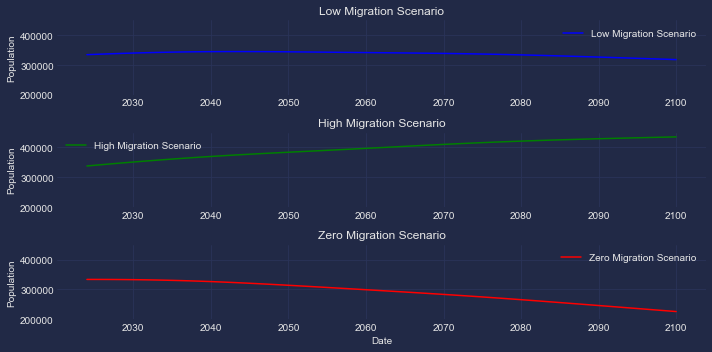

In [67]:
# Set 'Date' as the index if it's not already
df1.index = pd.to_datetime(df1.index, format='%Y')
df1 = df1[2:]

# Create a plot
plt.figure(figsize=(10, 5))  # Set the figure size for better visibility

# First Plot: Low Migration Scenario
plt.subplot(3, 1, 1)  # This means 3 rows, 1 column, first plot
plt.plot(df1['US_Proj-lo'], label='Low Migration Scenario', color='blue')
plt.title('Low Migration Scenario')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.ylim(200000, 450000)  # Set uniform y-axis limits

# Second Plot: High Migration Scenario
plt.subplot(3, 1, 2)  # This means 3 rows, 1 column, second plot
plt.plot(df1['US_Proj-hi'], label='High Migration Scenario', color='green')
plt.title('High Migration Scenario')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.ylim(200000, 450000)  # Set uniform y-axis limits

# Third Plot: Zero Migration Scenario
plt.subplot(3, 1, 3)  # This means 3 rows, 1 column, third plot
plt.plot(df1['US_Proj-0'], label='Zero Migration Scenario', color='red')
plt.title('Zero Migration Scenario')
plt.xlabel('Date')  # Only adding x-label to the bottom plot for clarity
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.ylim(200000, 450000)  # Set uniform y-axis limits

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/Pop_Growth_Estimates.jpeg', format='jpeg')

# Show the plot
plt.show()

In [68]:
# Assuming df1 has the 'Date' index as datetime at the start of each year
df1.index = pd.to_datetime(df1.index, format='%Y')

# Resample the DataFrame to quarterly, starting from the beginning of the year
pop_estimate_df = df1.resample('QS').asfreq()  # 'QS' stands for Quarter Start

# Apply interpolation
pop_estimate_df.interpolate(method='polynomial', order=3, inplace=True)

pop_estimate_df = np.log(pop_estimate_df)

# Check the resulting DataFrame
print(pop_estimate_df) # Show the last few rows to verify



            US_Proj-hi  US_Proj-lo  US_Proj-0
Date                                         
2024-01-01   12.730863   12.723249  12.717116
2024-04-01   12.732564   12.724014  12.717122
2024-07-01   12.734258   12.724773  12.717120
2024-10-01   12.735964   12.725533  12.717109
2025-01-01   12.737662   12.726285  12.717089
...                ...         ...        ...
2099-01-01   12.982568   12.675736  12.336965
2099-04-01   12.982898   12.675075  12.334791
2099-07-01   12.983230   12.674406  12.332589
2099-10-01   12.983565   12.673729  12.330356
2100-01-01   12.983899   12.673050  12.328118

[305 rows x 3 columns]


In [69]:
num_periods = 200
pop_estimate_df = pop_estimate_df.iloc[:num_periods]

pop_estimate_df = pop_estimate_df.iloc[:num_periods]

# Assuming `exog_forecasts_df` contains the exogenous forecasts with columns
# 'Log_USP_Forecast1', 'Log_USP_Forecast2', 'Log_USP_Forecast3'
pop_estimate_df['Log_USP'] = pop_estimate_df['US_Proj-hi']  # Assuming you want to use this column
pop_estimate = 'High Migration'  # For naming graphs or other outputs
pop_estimate_df
# Prepare the exogenous data for forecasting, ive found 5 lags gives the most realistic output


,US_Proj-hi,US_Proj-lo,US_Proj-0,Log_USP
Date,,,,
2024-01-01,12.730863,12.723249,12.717116,12.730863
2024-04-01,12.732564,12.724014,12.717122,12.732564
2024-07-01,12.734258,12.724773,12.717120,12.734258
2024-10-01,12.735964,12.725533,12.717109,12.735964
2025-01-01,12.737662,12.726285,12.717089,12.737662
...,...,...,...,...
2072-10-01,12.932560,12.732702,12.537895,12.932560
2073-01-01,12.933273,12.732383,12.536347,12.933273
2073-04-01,12.933967,12.732064,12.534823,12.933967


In [70]:
# Configure and fit the VECM model

# No Inflation

# Coint 4, Lag 5
# Coint 5, Lag 5

# Inflation

# Coint 5, Lag 5 ** Inflation
# Coint 6, Lag 5  ** Inflation 


vecm_model = VECM(endog = data[['Log_GDP','Log_USU', 'Log_USJO',
                                'Log_Inflation','Log_DJIA','GSADF_Stat']],
                  exog_coint = data[['Log_USP']],
                  k_ar_diff= 5, 
                  coint_rank=6, 
                  deterministic= 'ci')
vecm_result = vecm_model.fit()
vecm_result.summary()


forecast_df = vecm_result.predict(steps=num_periods, exog_coint_fc = pop_estimate_df['Log_USP'])
forecast_df

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1903: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  exog_coint_fc = exog_coint_fc[:, None]  # make 2-D


array([[15.552574  ,  8.72506199,  8.96395435,  5.73213469, 10.50950755,
         3.2058908 ],
       [15.55182088,  8.73794632,  8.88658186,  5.72810166, 10.38047328,
         2.64848572],
       [15.5454215 ,  8.8923148 ,  8.7418301 ,  5.72752669, 10.26195858,
         1.9987747 ],
       ...,
       [15.96884471,  9.26859005,  9.68068538,  6.23627059, 11.75520136,
         3.43978854],
       [15.96915755,  9.27531843,  9.6762324 ,  6.23710857, 11.75390679,
         3.41037469],
       [15.96952943,  9.28071607,  9.67286491,  6.23783283, 11.7532645 ,
         3.38575202]])

In [71]:
# Forecast of data
forecast_gdp = forecast_df[:, 0]
forecast_USU = forecast_df[:, 1]
forecast_USJO = forecast_df[:, 2]
forecast_Inflation = forecast_df[:, 3]
forecast_price = forecast_df[:,4 ]
forecast_gsadf = forecast_df[:, 5]






#Get the last date in price_df.index
last_date =  merged_df.index[-1]

# Add one quarter to the last date
forecast_date = last_date + relativedelta(months=+3)

# Create forecast_dates using pd.date_range
forecast_dates = pd.date_range(start=forecast_date, periods=len(forecast_df), freq='QS')
forecast_df = pd.DataFrame({
    'Log_DJIA': forecast_price,
    'Log_GDP': forecast_gdp,
    'Log_USJO': forecast_USJO,
    'Log_USU': forecast_USU,
    'Log_Inflation': forecast_Inflation,
    'GSADF_Stat': forecast_gsadf,

}, index=forecast_dates)
forecast_df




,Log_DJIA,Log_GDP,Log_USJO,Log_USU,Log_Inflation,GSADF_Stat
2024-01-01,10.509508,15.552574,8.963954,8.725062,5.732135,3.205891
2024-04-01,10.380473,15.551821,8.886582,8.737946,5.728102,2.648486
2024-07-01,10.261959,15.545422,8.741830,8.892315,5.727527,1.998775
2024-10-01,10.220053,15.546155,8.688769,8.960297,5.729343,1.895429
2025-01-01,10.198630,15.536946,8.558187,9.130220,5.727552,1.742361
...,...,...,...,...,...,...
2072-10-01,11.759967,15.968379,9.692965,9.251060,6.234231,3.514843
2073-01-01,11.757235,15.968587,9.686279,9.260490,6.235314,3.474814
2073-04-01,11.755201,15.968845,9.680685,9.268590,6.236271,3.439789
2073-07-01,11.753907,15.969158,9.676232,9.275318,6.237109,3.410375


In [72]:

# Assuming forecast_df and pop_estimate_df['Log_USP'] are the dataframes you're working with.
# First, ensure they are of the same length and have a proper index
if len(forecast_df) == len(pop_estimate_df):
    # Merge the DataFrames on their index if they are indeed indexed the same way
    forecast_df = pd.merge(forecast_df, pop_estimate_df[['Log_USP']], left_index=True, right_index=True)
else:
    print("The lengths of forecast_df and pop_estimate_df do not match. Adjustment needed.")

# Check the resulting DataFrame
print(forecast_df)


             Log_DJIA    Log_GDP  Log_USJO   Log_USU  Log_Inflation  \
2024-01-01  10.509508  15.552574  8.963954  8.725062       5.732135   
2024-04-01  10.380473  15.551821  8.886582  8.737946       5.728102   
2024-07-01  10.261959  15.545422  8.741830  8.892315       5.727527   
2024-10-01  10.220053  15.546155  8.688769  8.960297       5.729343   
2025-01-01  10.198630  15.536946  8.558187  9.130220       5.727552   
...               ...        ...       ...       ...            ...   
2072-10-01  11.759967  15.968379  9.692965  9.251060       6.234231   
2073-01-01  11.757235  15.968587  9.686279  9.260490       6.235314   
2073-04-01  11.755201  15.968845  9.680685  9.268590       6.236271   
2073-07-01  11.753907  15.969158  9.676232  9.275318       6.237109   
2073-10-01  11.753265  15.969529  9.672865  9.280716       6.237833   

            GSADF_Stat    Log_USP  
2024-01-01    3.205891  12.730863  
2024-04-01    2.648486  12.732564  
2024-07-01    1.998775  12.734258  
202

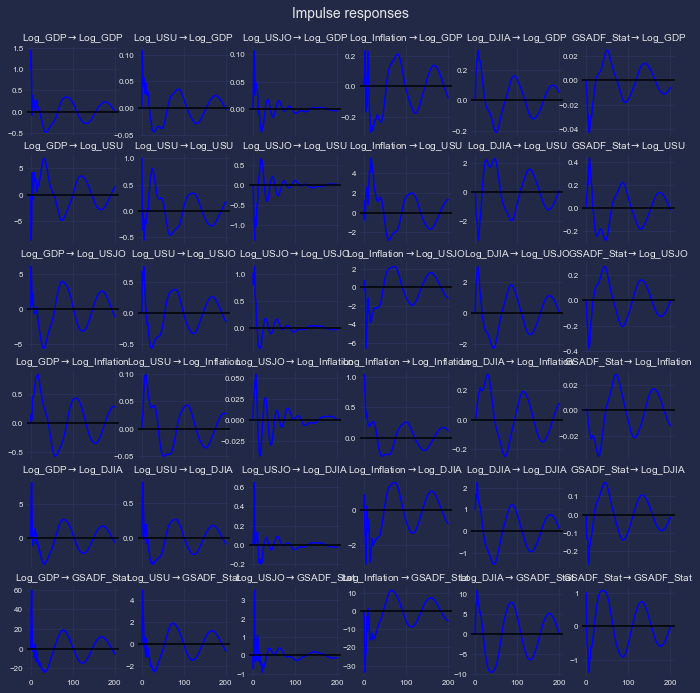

In [73]:
ir = vecm_result.irf(periods=num_periods)
fig = ir.plot(plot_stderr=False)

# Adjust the font size of the labels
for ax in fig.axes:
    ax.title.set_fontsize(10)  # Adjust title font size
    ax.xaxis.label.set_fontsize(8)  # Adjust x-axis label font size
    ax.yaxis.label.set_fontsize(8)  # Adjust y-axis label font size
    ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust tick labels font size
plt.savefig(f'/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/{pop_estimate} IRF.jpeg', format='jpeg')

# Show the plot
plt.show()




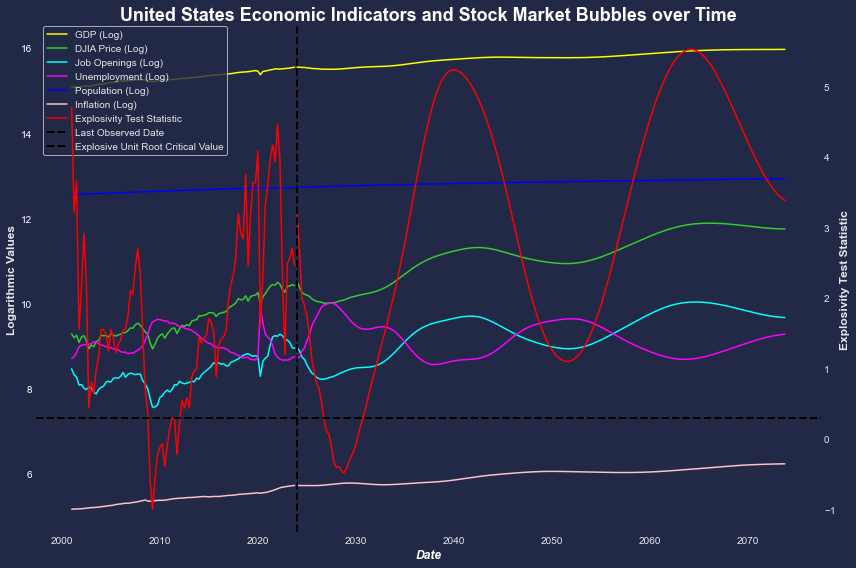

In [74]:
# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))


# Plotting all logarithmic data on the primary left y-axis
ax1.set_xlabel('Date', style='italic', color=axis_color, fontsize=12, fontweight='bold')
ax1.set_ylabel('Logarithmic Values', fontsize=12, fontweight='bold')
ax1.plot(merged_df.index, merged_df['Log_GDP'], color=color_gdp, label='GDP (Log)')
ax1.plot(merged_df.index, merged_df['Log_DJIA'], color=color_stock_index, label='DJIA Price (Log)')
ax1.plot(merged_df.index, merged_df['Log_USJO'], color=color_job_openings, label='Job Openings (Log)')
ax1.plot(merged_df.index, merged_df['Log_USU'], color=color_unemployment, label='Unemployment (Log)')
ax1.plot(merged_df.index, merged_df['Log_USP'], color=color_population, label='Population (Log)')  # New population line
ax1.plot(merged_df.index, merged_df['Log_Inflation'], color=color_inflation, label='Inflation (Log)')  # New population line

# Optional: Forecast data plotting
ax1.plot(forecast_df.index, forecast_df['Log_GDP'], linestyle='-', color=color_gdp, label='GDP (Log)')
ax1.plot(forecast_df.index, forecast_df['Log_DJIA'], linestyle='-', color=color_stock_index, label='DJIA Price (Log)')
ax1.plot(forecast_df.index, forecast_df['Log_USJO'], linestyle='-', color=color_job_openings, label='Job Openings (Log)')
ax1.plot(forecast_df.index, forecast_df['Log_USU'], linestyle='-', color=color_unemployment, label='Unemployment (Log)')
ax1.plot(forecast_df.index, forecast_df['Log_USP'], linestyle='-', color=color_population, label='Population (Log)') 
ax1.plot(forecast_df.index, forecast_df['Log_Inflation'], color=color_inflation, label='Inflation (Log)')  # New population line

ax1.tick_params(axis='y', labelcolor=axis_color, labelsize=10)
ax1.grid(False)  

# Create a second y-axis for the GSADF Statistic data
ax2 = ax1.twinx()
ax2.set_ylabel('GSADF Statistic', fontsize=12, fontweight='bold')
ax2.plot(merged_df.index, merged_df['GSADF_Stat'], color=color_bsadf_stat, label='Explosivity Test Statistic')
ax2.plot(forecast_df.index, forecast_df['GSADF_Stat'], linestyle='-', color=color_bsadf_stat, label='Explosivity Test Statistic')
ax2.set_ylabel('Explosivity Test Statistic', fontsize=12, fontweight='bold')
ax2.grid(False) 

# Adding a vertical line for the last observed date
last_observed_date = forecast_df.index[0]  # Assuming forecast_df.index contains the dates
plt.axvline(x=last_observed_date, color='black', linestyle='--', linewidth=2, label='Last Observed Date')


# Title and legend handling
plt.title(f'{select} Economic Indicators and Stock Market Bubbles over Time', color=axis_color, fontsize=18, fontweight='bold')
fig.tight_layout()

# Collecting handles and labels from both axes for a unified legend, avoiding duplicates
handles, labels = [], []
for ax in [ax1, ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)
ax1.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.25,1.01), frameon = True)

# Save and show the plot
plt.savefig(f'/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/{pop_estimate}_Model.jpeg', format='jpeg')
plt.show()


In [75]:
merged_df = pd.concat([data, forecast_df], axis=0)

# Check the resulting DataFrame
print(merged_df)

             Log_DJIA    Log_GDP  Log_USJO   Log_USU    Log_USP  \
2001-01-01   9.286083  15.081269  8.466321  8.713472  12.557324   
2001-04-01   9.198144  15.087494  8.324821  8.752581  12.559676   
2001-07-01   9.259359  15.083480  8.278174  8.842508  12.562291   
2001-10-01   9.087897  15.086224  8.086103  8.985320  12.564834   
2002-01-01   9.212488  15.094553  8.098339  9.015987  12.567011   
...               ...        ...       ...       ...        ...   
2072-10-01  11.759967  15.968379  9.692965  9.251060  12.932560   
2073-01-01  11.757235  15.968587  9.686279  9.260490  12.933273   
2073-04-01  11.755201  15.968845  9.680685  9.268590  12.933967   
2073-07-01  11.753907  15.969158  9.676232  9.275318  12.934664   
2073-10-01  11.753265  15.969529  9.672865  9.280716  12.935364   

            Log_Inflation  GSADF_Stat  
2001-01-01       5.169916    4.704444  
2001-04-01       5.176903    3.216151  
2001-07-01       5.179722    3.660219  
2001-10-01       5.178971    1.5573

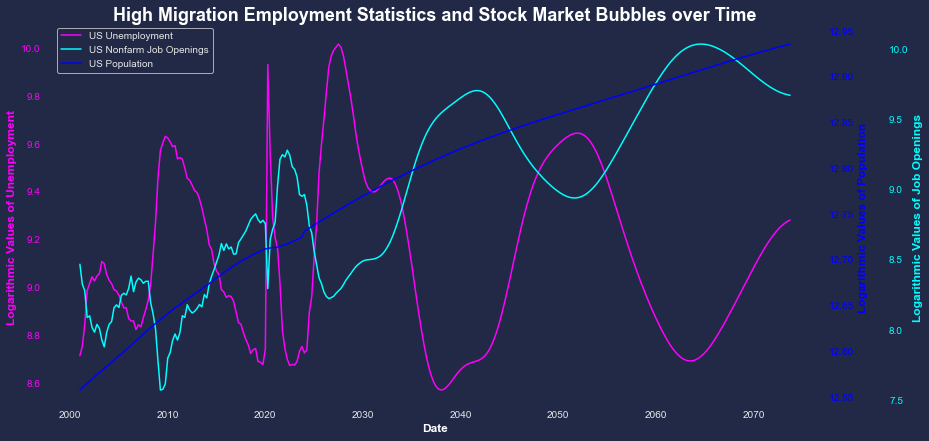

In [76]:
# Initialize the figure and primary axis
plt.figure(figsize=(14, 7))
ax1 = plt.gca()

# Plotting Unemployment on the primary y-axis
lines1 = ax1.plot(merged_df.index, merged_df['Log_USU'], label='Log of US Unemployment', color=color_unemployment)
ax1.set_xlabel('Date', fontsize=12, fontweight='bold', color=axis_color)
ax1.set_ylabel('Logarithmic Values of Unemployment', fontsize=12, fontweight='bold', color=color_unemployment)
ax1.tick_params(axis='y', colors=color_unemployment)
ax1.grid(False)

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset the third axis correctly
lines2 = ax2.plot(merged_df.index, merged_df['Log_USJO'], label='Log of US Job Openings', color=color_job_openings)
ax2.set_ylabel('Logarithmic Values of Job Openings', fontsize=12, fontweight='bold', color=color_job_openings)
ax2.tick_params(axis='y', colors=color_job_openings)
ax2.grid(False)

# Create a second y-axis for Explosivity Test Statistic
ax3 = ax1.twinx()
lines3 = ax3.plot(merged_df.index, merged_df['Log_USP'], label='Population', color= color_population)
ax3.set_ylabel('Logarithmic Values of Population', fontsize=12, fontweight='bold', color=color_population)
ax3.tick_params(axis='y', colors=color_population)
ax3.grid(False)

# Create a third y-axis for Employment


# Title and legend handling
plt.title(f'{pop_estimate} Employment Statistics and Stock Market Bubbles over Time', fontsize=18, fontweight='bold', color=axis_color)

# Define labels
labels = ['US Unemployment', 'US Nonfarm Job Openings', 'US Population']
lines = [lines1[0], lines2[0], lines3[0]]  # Extracting the first element since plot returns a list of Line2D objects

ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.01, 1.01), frameon=True)

# Save the plot to a file
plt.savefig(f'/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/{pop_estimate} Unemployment_Test_Stat_F.jpeg', format='jpeg')

# Display the plot
plt.show()


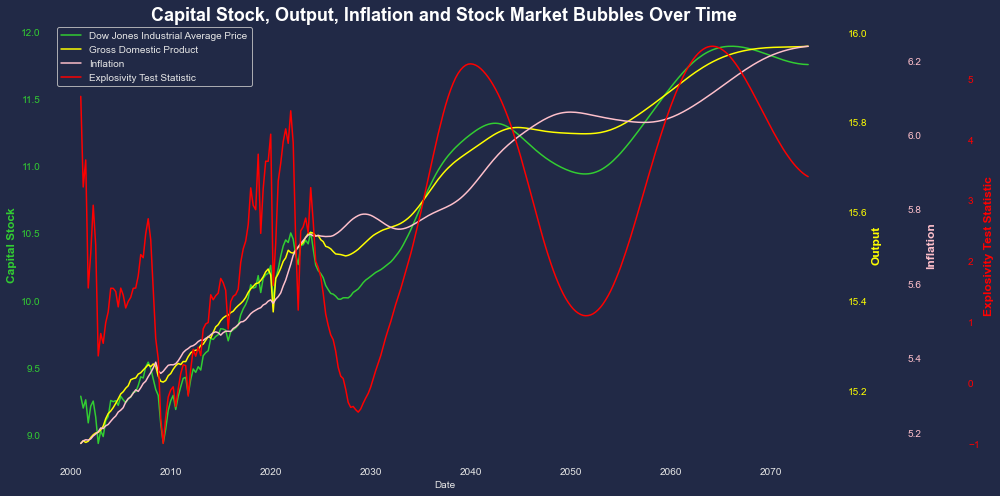

In [77]:


fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Price data on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Capital Stock', fontsize=12, fontweight='bold', color=color_stock_index)
line1, = ax1.plot(merged_df.index, merged_df['Log_DJIA'], color=color_stock_index, label='Dow Jones Industrial Average Price')
ax1.tick_params(axis='y', labelcolor=color_stock_index)
ax1.grid(False)  

# Create a second y-axis for the GDP data
ax2 = ax1.twinx()  
ax2.set_ylabel('Output', fontsize=12, fontweight='bold', color=color_gdp)
line2, = ax2.plot(merged_df.index, merged_df['Log_GDP'], color=color_gdp, label='Gross Domestic Product')
ax2.tick_params(axis='y', labelcolor=color_gdp)
ax2.grid(False)  

# Create a third y-axis for the Inflation data
ax3 = ax1.twinx()  
ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Inflation', fontsize=12, fontweight='bold', color=color_inflation)
line3, = ax3.plot(merged_df.index, merged_df['Log_Inflation'], color=color_inflation, label='Inflation')
ax3.tick_params(axis='y', labelcolor=color_inflation)
ax3.grid(False)  

# Create a fourth y-axis for the Explosivity Test Statistic
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.set_ylabel('Explosivity Test Statistic', fontsize=12, fontweight='bold', color=color_bsadf_stat)
line4, = ax4.plot(merged_df.index, merged_df['GSADF_Stat'], color=color_bsadf_stat, label='Explosivity Test Statistic')
ax4.tick_params(axis='y', labelcolor=color_bsadf_stat)
ax4.grid(False) 

# Title and layout
plt.title(f'Capital Stock, Output, Inflation and Stock Market Bubbles Over Time', color=axis_color, fontsize=18, fontweight='bold')
fig.tight_layout()  

# Add a legend to the plot
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.01, 1.01), frameon=True)

# Save the plot to the specified directory and file
plt.savefig(f'/Users/philiplacava/Desktop/Asset-Price-Bubble-Detection/results/{pop_estimate}_Index_Price_GDP_F.jpeg', format='jpeg')

# Show the plot
plt.show()
